# Data Challenge 11 — Evaluating MLR & Fixing Multicollinearity (HVFHV Trips)


**Format:** Instructor Guidance → You Do (Students) → We Share (Reflection)

**Goal:** Build an MLR, evaluate it with a **train–test split**, diagnose multicollinearity with **corr** and **VIF** on the **training set**, fix issues (drop/choose features), and report **test MAE/RMSE** + **coefficient interpretations**.

**Data:** July 1, 2023 - July 15, 2023 For Hire Vehicle Data in NYC

[July For Hire Vehicles Data](https://data.cityofnewyork.us/Transportation/2023-High-Volume-FHV-Trip-Data/u253-aew4/about_data)


## Instructor Guidance

**Hint: Use the Lecture Deck, Canvas Reading, and Docs to help you with the code**

Use this guide live; students implement below.

**Docs (quick links):**
- Train/Test Split — scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
- OLS — statsmodels: https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLS.html
- OLS Results (rsquared_adj, pvalues, resid, etc.): https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.RegressionResults.html
- VIF — statsmodels: https://www.statsmodels.org/stable/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html
- Corr — pandas: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html

### Pseudocode Plan (Evaluation + Multicollinearity)
1) **Load CSV** → preview shape/columns; (optional) filter to **July**.
2) **Pick Y** (`base_passenger_fare`) and **candidate X’s** (e.g., `trip_miles`, `trip_time_minutes`, `tolls`, `tips` if present).
3) **Light prep** → derive `trip_time_minutes` from `trip_time` (seconds) if present; coerce only used cols to numeric; drop NA rows.
4) **Split** → `X_train, X_test, y_train, y_test` (80/20, fixed `random_state`).
5) **Diagnose on TRAIN**:
   - **Correlation matrix** (|r| > 0.7 = red flag).
   - **VIF** for each predictor (1–5 ok; >5–10+ = concerning).
6) **Fix** → drop/choose among highly correlated predictors (business logic).
7) **Fit on TRAIN only** → OLS with intercept.
8) **Predict on TEST** → compute **MAE/RMSE** (units of Y).
9) **Interpret** → unit-based coefficient sentences **holding others constant**; note any changes after fixing collinearity.
10) **Report** → table of (features kept, Adj R², MAE, RMSE) + 1-line stakeholder takeaway.


## You Do — Student Section
Work in pairs. Comment your choices briefly. Keep code simple—only coerce the columns you use.

### Step 0 — Setup & Imports

In [54]:
import statsmodels.api as sm
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split

### Step 1 — Load CSV & Preview
- Point to your For Hire Vehicle Data 
- Print **shape** and **columns**.

**Hint: You may have to drop missing values and do a force coercion to make sure the variables stay numeric (other coding assignments may help)**

In [55]:
df = pd.read_csv('/Users/Marcy_Student/Desktop/Marcy_Lab/DA2025_Lectures/Mod6/data/FHV_072023 copy.csv')

/var/folders/h0/75t8pd8571n2l1zzjcyqp7kh0000gp/T/ipykernel_9581/1390884072.py:1: DtypeWarning: Columns (11,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/Marcy_Student/Desktop/Marcy_Lab/DA2025_Lectures/Mod6/data/FHV_072023 copy.csv')


In [56]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

/var/folders/h0/75t8pd8571n2l1zzjcyqp7kh0000gp/T/ipykernel_9581/4065909773.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
/var/folders/h0/75t8pd8571n2l1zzjcyqp7kh0000gp/T/ipykernel_9581/4065909773.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])


In [57]:
df = df[(df['pickup_datetime'] >= '2023-07-01') & (df['pickup_datetime'] < '2023-07-16')]

In [58]:
display(df.head())
display(df.info())

,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,...,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
0,HV0005,B03406,NaN,07/01/2023 05:34:30 PM,NaN,2023-07-01 17:37:48,2023-07-01 17:44:45,158,68,1.266,...,1.35,2.75,0.0,2.00,5.57,N,N,N,N,False
1,HV0003,B03404,B03404,07/01/2023 05:34:30 PM,07/01/2023 05:36:53 PM,2023-07-01 17:37:15,2023-07-01 17:55:15,162,234,2.350,...,1.52,2.75,0.0,3.28,13.38,N,N,NaN,N,False
2,HV0003,B03404,B03404,07/01/2023 05:34:30 PM,07/01/2023 05:35:17 PM,2023-07-01 17:35:52,2023-07-01 17:44:27,161,163,0.810,...,0.49,2.75,0.0,0.00,5.95,N,N,NaN,N,False
3,HV0003,B03404,B03404,07/01/2023 05:34:30 PM,07/01/2023 05:37:39 PM,2023-07-01 17:39:35,2023-07-01 18:23:02,122,229,15.470,...,5.17,2.75,0.0,0.00,54.46,N,N,NaN,N,True
4,HV0003,B03404,B03404,07/01/2023 05:34:30 PM,07/01/2023 05:36:06 PM,2023-07-01 17:36:39,2023-07-01 17:45:06,67,14,1.520,...,0.85,0.00,0.0,3.00,7.01,N,N,NaN,N,False


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8324591 entries, 0 to 8324590
Data columns (total 24 columns):
 #   Column                Dtype         
---  ------                -----         
 0   hvfhs_license_num     object        
 1   dispatching_base_num  object        
 2   originating_base_num  object        
 3   request_datetime      object        
 4   on_scene_datetime     object        
 5   pickup_datetime       datetime64[ns]
 6   dropoff_datetime      datetime64[ns]
 7   PULocationID          int64         
 8   DOLocationID          int64         
 9   trip_miles            float64       
 10  trip_time             object        
 11  base_passenger_fare   object        
 12  tolls                 float64       
 13  bcf                   float64       
 14  sales_tax             float64       
 15  congestion_surcharge  float64       
 16  airport_fee           float64       
 17  tips                  float64       
 18  driver_pay            object        
 19  

None

In [59]:
df[['trip_miles','trip_time', 'base_passenger_fare','tolls','airport_fee','tips','congestion_surcharge' ]]

,trip_miles,trip_time,base_passenger_fare,tolls,airport_fee,tips,congestion_surcharge
0,1.266,417,15.18,0.0,0.0,2.00,2.75
1,2.350,"1,080",17.15,0.0,0.0,3.28,2.75
2,0.810,515,5.57,0.0,0.0,0.00,2.75
3,15.470,"2,607",58.23,0.0,0.0,0.00,2.75
4,1.520,507,9.61,0.0,0.0,3.00,0.00
...,...,...,...,...,...,...,...
8324586,8.270,"1,549",25.92,0.0,0.0,0.00,0.00
8324587,1.830,645,11.86,0.0,0.0,5.00,2.75
8324588,2.220,"1,309",25.91,0.0,0.0,0.00,2.75
8324589,3.050,900,15.18,0.0,0.0,0.00,0.00


In [60]:
df.columns

Index(['hvfhs_license_num', 'dispatching_base_num', 'originating_base_num',
       'request_datetime', 'on_scene_datetime', 'pickup_datetime',
       'dropoff_datetime', 'PULocationID', 'DOLocationID', 'trip_miles',
       'trip_time', 'base_passenger_fare', 'tolls', 'bcf', 'sales_tax',
       'congestion_surcharge', 'airport_fee', 'tips', 'driver_pay',
       'shared_request_flag', 'shared_match_flag', 'access_a_ride_flag',
       'wav_request_flag', 'wav_match_flag'],
      dtype='object')

In [61]:
# Coerce fare, tip, distance to numeric safely
num_cols = ['PULocationID', 'trip_time', 'DOLocationID', 'trip_miles', 'base_passenger_fare', 'tolls', 'airport_fee', 'tips', 'congestion_surcharge']
for c in num_cols:
    df[c] = pd.to_numeric(
        df[c].astype(str).str.strip().str.replace(r'[^0-9.+\-eE]', '', regex=True),
        errors='coerce')
# Clean data some and add a new column called ‘tip_pct’ as the target
df = df[(df['trip_miles'] > 0) & (df['base_passenger_fare'] > 0) & (df['tips'] >= 0) & (df['congestion_surcharge'] > 0) & (df['trip_time'] > 0)]
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=num_cols)

### Step 2 —  Choose Target **Y** and Candidate Predictors

- Suggested **Y**: `base_passenger_fare` (USD).
- Start with **distance** and **time**; optionally add **flags** if present.
- Derive `trip_time_minutes` from `trip_time` (seconds) if available.

In [62]:
list_col = ['trip_miles', 'trip_time', 'tips', 'base_passenger_fare']
for _ in list_col:
    Q1 = df[_].quantile(0.25)
    Q3 = df[_].quantile(0.99)
    IQR = Q3 - Q1
    df = df[(df[_] >= Q1 - 1.5*IQR) & (df[_] <= Q3 + 1.5*IQR)]

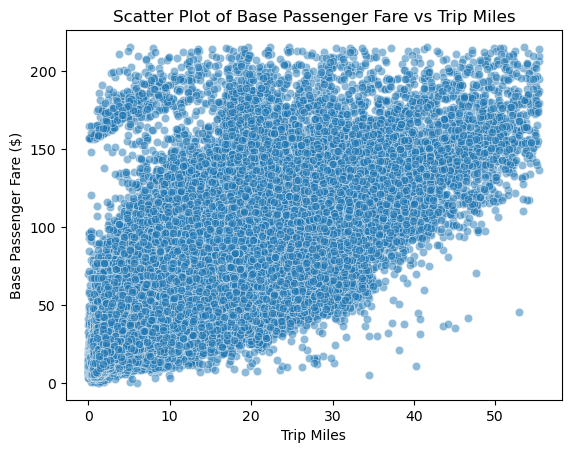

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=df, x='trip_miles', y='base_passenger_fare', alpha=0.5)
plt.title('Scatter Plot of Base Passenger Fare vs Trip Miles')
plt.xlabel('Trip Miles')
plt.ylabel('Base Passenger Fare ($)')
plt.show()

### Step 3 — Train–Test Split

- Use a fixed `random_state` for reproducibility.
- **All diagnostics below must be done on TRAIN only.**

In [ ]:
import statsmodels.api as sm

# Define target and predictors
y = df['base_passenger_fare']             
X = df[['trip_miles', 'trip_time','tips']]
X = sm.add_constant(X)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Step 4 — Diagnose Multicollinearity on **TRAIN** — Correlation Matrix
- Flag any |r| > 0.70 as a potential problem.


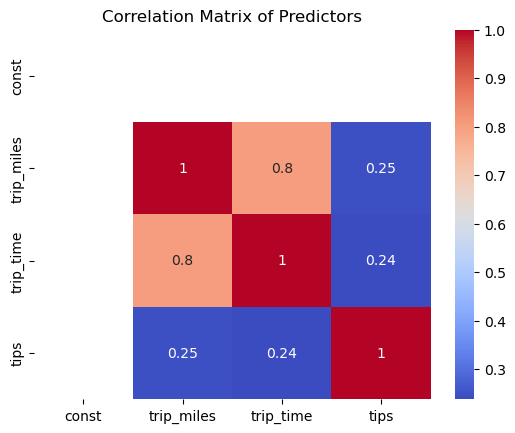

In [70]:
corr_matrix = X_train.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Predictors')
plt.show()


### Step 5 — Diagnose Multicollinearity on **TRAIN** — VIF
- 1–5 normal; >5–10+ concerning.

In [71]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# Add a constant for intercept
X_train_const = sm.add_constant(X_train)

# Compute VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i)
                   for i in range(len(X_train.columns))]
print(vif_data)

      feature       VIF
0       const  3.767501
1  trip_miles  2.836924
2   trip_time  2.824684
3        tips  1.069864


VIF is between 1-5, so there is a moderate corellattion between the variable and the response variable.
But the heat show us that there is strong positive correlation between `trip_time` and `trip_mile`, since 0.8 > 0.7 the threshold (our rules of thumbs)
we can decide to drop one of the variables or combine them into single variable by creating a new feature.

### Step 6 — Fix High VIF (if needed)

- If two predictors are highly correlated, **drop/choose** using business logic (e.g., keep the more actionable one).
- Recompute VIF to confirm improvement.

Let's drop `trip_time` because we are trying to predict the fare amount, so the `trip_distance` make more scence in this scenario

In [73]:
import statsmodels.api as sm

# Define target and predictors
y_b = df['base_passenger_fare']             
X_b = df[['trip_miles','tips']]
X_b = sm.add_constant(X_b)
# Split the data into training and testing sets
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_b, y_b, test_size=0.2, random_state=42)

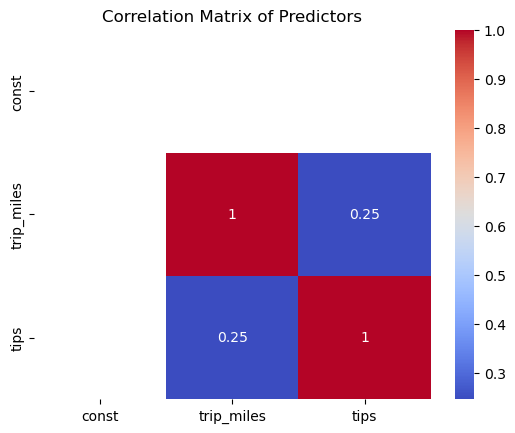

In [74]:
corr_matrix_b = X_train_b.corr()
sns.heatmap(corr_matrix_b, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Predictors')
plt.show()

In [75]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# Add a constant for intercept
X_train_const_b = sm.add_constant(X_train_b)

# Compute VIF for each feature
vif_data_b = pd.DataFrame()
vif_data_b["feature"] = X_train_b.columns
vif_data_b["VIF"] = [variance_inflation_factor(X_train_b.values, i)
                   for i in range(len(X_train_b.columns))]
print(vif_data_b)

      feature       VIF
0       const  2.092486
1  trip_miles  1.064679
2        tips  1.064679


### Step 7 —  Fit on TRAIN Only, Predict on TEST, Evaluate MAE/RMSE

- Add intercept (`sm.add_constant`).
- Report **MAE/RMSE** in **units of Y**.
- Also capture **Adjusted R²** from the TRAIN fit summary to comment on fit (don’t use it alone for selection).


In [76]:
# Fit the OLS regression model
model = sm.OLS(y_train_b, X_train_b).fit()
# Print the model summary
print(model.summary())

                             OLS Regression Results                            
Dep. Variable:     base_passenger_fare   R-squared:                       0.722
Model:                             OLS   Adj. R-squared:                  0.722
Method:                  Least Squares   F-statistic:                 3.365e+06
Date:                 Sat, 08 Nov 2025   Prob (F-statistic):               0.00
Time:                         00:35:38   Log-Likelihood:            -9.5521e+06
No. Observations:              2591346   AIC:                         1.910e+07
Df Residuals:                  2591343   BIC:                         1.910e+07
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.6238      0.009   1224.82

In [77]:
# Predictions
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test_b)

# Evaluate
print("R²:", r2_score(y_test_b, y_pred))
print("RMSE:", mean_squared_error(y_test_b, y_pred))

R²: 0.721327478116685
RMSE: 92.80662607677331


### Step 8 — Interpret Coefficients (Plain Language)
Write **unit-based** sentences “**holding others constant**.” Example templates (edit with your β values/units):

- **trip_miles:** “Holding other variables constant, each additional **1 mile** is associated with **+$1.8818** in **base fare**.”
- **trip_time_minutes:** “Holding others constant, each additional **1 minute** is associated with **+$0.0091** in **base fare**.”
- **tips:** Increase the base passenger fare by $1 for each change, holding the others constant.
- **p-values: 0.000** mean there is a statistically significant relationship between the variable and the target.

## We Share — Reflection & Wrap‑Up

Write **2 short paragraphs** and be specific:

1) **What changes did you make to handle multicollinearity and why?**  
Reference **corr**/**VIF** on TRAIN and any features you dropped or kept (with business rationale). Include **Adjusted R² (TRAIN)** and **TEST MAE/RMSE**.  

- To handle multicollinearity, I used two methods: first, I used a Correlation Matrix, which is a table that shows how strongly variables are related to each other, and next, VIF (Variance Inflation Factor), a more advanced technique that flags highly correlated variables. After checking the correlation using the heatmap, I observed a high correlation between `trip_time` and `trip_distance`. This multicollinearity can be a problem for our model to detect the true effect of each variable on the target. The model can be confused if the increase in the base passenger fare is due to `trip_distance` or `trip_time`. I decided to drop the `trip_time` variable because `trip_distance` is more meaningful when predicting the passenger fare amount. Also, the Adj. R-squared on the train data is about 0.72, meaning it explains 72% of the fare amount variance without overfitting.

2) **Stakeholder summary (units, one sentence):**  
- On unseen July trips, our typical error is about **$1** per fare; each extra mile adds about **$2.91**, holding other factors constant.
